In [22]:
# 이 예제는 신경망이 학습한 패턴을 시각화 하는 실험이며 사람이 상상할때 한가지 형상에서 여러가지 모습을 생각하듯 DeepDream은 주어진 이미지 내의 있는 패턴을 향상(새데이터 생성) 및 과잉해석(데이터 판별)을 합니다.

In [23]:
# 순서는 신경망을 통해 입력 > 은닉 > 출력 순으로 이미지를 순전파 하며 특정 층의 활성화값에 대한 이미지의 경사를 계산함으로써 구현됨 이때 DeepDream Algorism은 층의 활성화 값을 최대화 하도록 이미지를 수정(생성) 
# 하는데 이는 신경망이 과잉해석을 하도록 유도함 이로써 입력 이미지를 기반으로 몽환적인 이미지를 만들어 낼수 있게됨.

In [24]:
# tensorflow : 다양한 작업에 대해 데이터 흐름 프로그래밍을 위한 오픈소스 라이브러리 딥러닝 프로그램을 쉽게 구현 가능하게 도와줌.
import tensorflow as tf
# numpy : 행렬, 다차원 배열 등을 쉽게 처리할수 있도록 지원하는 라이브러리. 선형대수 관련 기능 지원, 반복문 없이 데이터 배열 처리 지원
import numpy as np
# IPython.display : 출력값을 연속해서 모두 출력하게 해줌.
import IPython.display as display
# PIL.Image : 이미지 분석 및 처리를 지원하는 라이브러리 PIL은 Python Imaging Library의 약자
import PIL.Image
# Keras : 여러 머신러닝 라이브러리 에서 작동하는 프레임워크
from tensorflow.keras.preprocessing import image
# time : 시간 관련 라이브러리
import time

In [25]:
url = "https://previews.123rf.com/images/dink101/dink1011209/dink101120900071/15318748-%ED%94%84%EB%9D%BC%ED%95%98%EC%9D%98-%EA%B1%B0%EB%A6%AC-%EC%B2%B4%EC%BD%94.jpg?fj=1" #임의의 이미지 사용.

In [26]:
# 전처리
# 이미지를 다운로드 하여 넘파이 배열로 변환
def download(url, max_dim = None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin = url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

In [27]:
# 이미지 정규화 
# 정규화 : 데이터의 크기가 다를경우 특징들의 중요도가 각각 달라질수 있음 이를 방지하기 위하여 데이터의 크기(Scale)를 동일하게 만듬
def deprocess(img):
    img = 255 * (img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

In [28]:
# 이미지 출력 함수
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

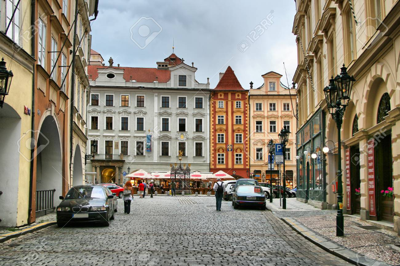

In [29]:
# 이미지의 크기를 축소하여 작업에 용이하게 변경.
original_img = download (url, max_dim= 400)
show(original_img)
display.display(display.HTML('Image cc-by: <a "https://previews.123rf.com/images/dink101/dink1011209/dink101120900071/15318748-%ED%94%84%EB%9D%BC%ED%95%98%EC%9D%98-%EA%B1%B0%EB%A6%AC-%EC%B2%B4%EC%BD%94.jpg?fj=1">구글링해서 찾은 이미지</a>'))

In [30]:
# 빠른 진행을 위해 사전 훈련된 이미지 모델 사용 
# 사용 모델명 InceptionV3 # ImageNet 으로 학습한 가중치를 바탕으로 진행.
base_model =tf.keras.applications.InceptionV3(include_top = False, weights = "imagenet")

In [31]:
# 선택한 층들의 활성화 값을 최대화
# 합성곱층은 mixed0 ~ mixed 10 까지 총 11개의 층이 있음 층이 낮으면 선, 모양, 질감 등의 저차원 데이터 층이 높으면 눈, 얼굴 같은 고차원 데이터에 반응함. Ex) 점과 선이(저차원) 모여 얼굴(고차원) 과 같은 형태가 구성됨. 
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names ]

# 특성 추출 모델 생성
dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [32]:
#손실률 계산
def calc_loss(img, model):
    # 이미지를 순전파 하여 모델의 활성화 값 파악 
    # 이미지의 배치 크기를 1로 만듬
    # 배치(batch) : 데이터 셋을 여러 작은 그룹으로 나누었을때 하나의 소그룹에 속하는 데이터의 수 
    img_batch = tf.expand_dims(img, axis = 0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [33]:
# 손실률은 원래 경사 하강법으로 최소화 하어야 하나 DeepDream에서는 예외적으로 경사 상승법을 사용하여 최대화 하여 패턴을 극대화 시킴.
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape = [None, None, 3], dtype = tf.float32),
            tf.TensorSpec(shape = [], dtype = tf.int32),
            tf.TensorSpec(shape = [], dtype = tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("추적")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
            gradients = tape.gradient(loss, img)

            gradients /= tf.math.reduce_std(gradients) + 1e-8 # 1의 -8승 으로 스케일 축소 

            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
        
        return loss, img

In [34]:
deepdream = DeepDream(dream_model)

In [35]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0 
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)      
        else:
            run_steps = tf.constant(steps_remaining)  
        steps_remaining -= run_steps 
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait = True) 
        show(deprocess(img))
        print (f"Step {step}, Loss {loss}")

    result = deprocess(img)
    display.clear_output(wait = True)
    show(result)

    return result  
    

기존 이미지


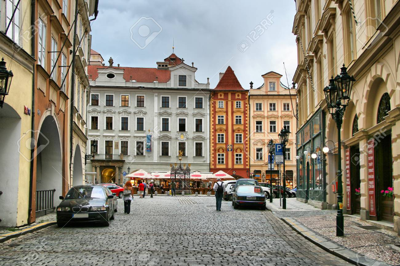

In [36]:
print("기존 이미지")
show(original_img)

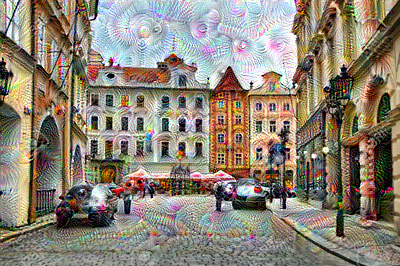

In [37]:
print("새롭게 생성된 이미지")
dream_img = run_deep_dream_simple(img = original_img,
                                  steps = 100, step_size = 0.01)

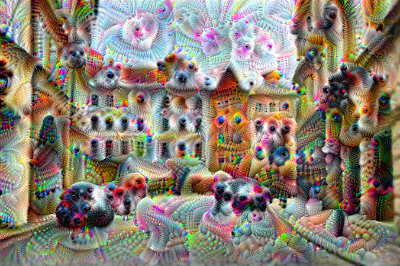

소요된 시간


159.68586564064026

In [38]:
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps = 50, step_size = 0.01)

display.clear_output(wait = True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)

show(img)

end = time.time()
print("소요된 시간")
end - start

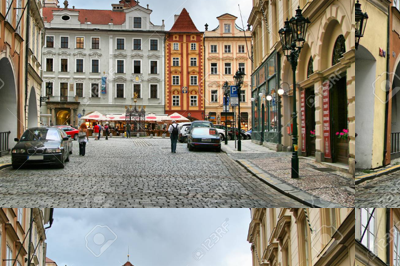

In [39]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape = [2], minval = -maxroll, maxval = maxroll, dtype = tf.int32)
    shift_down, shift_right = shift[0], shift[1]
    img_rolled = tf.roll(tf.roll(img, shift_right, axis = 1), shift_down, axis = 0)
    return shift_down, shift_right, img_rolled

shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 786)
show(img_rolled)

In [40]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature = (
            tf.TensorSpec(shape = [None, None, 3], dtype = tf.float32),
            tf.TensorSpec(shape = [], dtype = tf.int32),)
    )

    def __call__(self, img, tile_size = 512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)

        gradients = tf.zeros_like(img_rolled)

        xs = tf.range(0, img_rolled.shape[0], tile_size) [:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size) [:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)

                    img_tile = img_rolled[x : x + tile_size, y : y + tile_size]
                    loss = calc_loss(img_tile, self.model)
                gradients = gradients + tape.gradient(loss, img_rolled)
        gradients = tf.roll(tf.roll(gradients, -shift_right, axis = 1), -shift_down, axis = 0)

        gradients /= tf.math.reduce_std(gradients) + 1e-8

        return gradients

get_tiled_gradients = TiledGradients(dream_model)

In [41]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.5):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # 옥타브에 따라 이미지의 크기를 조정합니다.
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print (f"옥타브 {octave}, 단계 {step}")

  result = deprocess(img)
  return result

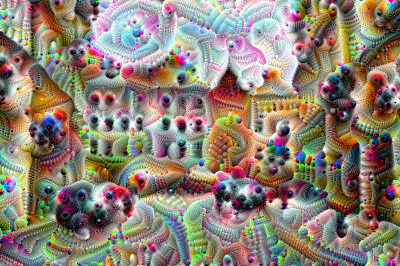

In [42]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)